# Exercise 8 Blob detection for SIFT discription

These exercises will introduce you to blobs and SIFT features. In this exercise you will write the \
code for the blob detector as well as use the SIFT feature detector and matcher.

**Blob detector**
You will implement a blob detector using the Difference-of-Gaussian (DoG) method and apply it \
to the sample image of sunflowers.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

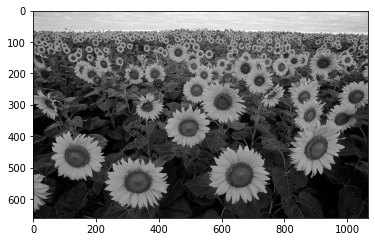

In [3]:
# Load image
img = cv2.imread('sunflowers.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap="gray")

#### 8.1 Scaling

Create the function ```im_scales = scaleSpaced(im, sigma, n)```, where im_scales is a scale pyramid of the original image im.  \
The width and height of all images in the pyramid im_scales are exactly the same as the original image im. In other words \
im_scales is *not a pyramid in image sizes; only in scale space*. 


This function should apply a Gaussian kernel of width $\sigma 2^i$, \
(where i = 0, 1, . . . , n − 1.)

**NB** This is providing the gaussians that we will then use to create DoG images used in blob detection!

In [4]:
def gaussianSmoothing(im, sigma): # From week 6
    """
    Returns the gaussian smoothed image I, and the image derivatives Ix and Iy.
    """
    # 1 obtain the kernels for gaussian and for differentiation.
    g, gx, _ = gaussian1DKernel(sigma=sigma)
    # 2 Filter the image in both directions and diff in both directions
    I = cv2.filter2D(cv2.filter2D(im, -1, g), -1, g.T) # smooth I = g * g.T * I
    # 3 Differentiate - d/dx I = g * gx.T * I 
    Ix = cv2.filter2D(cv2.filter2D(im, -1, gx.T), -1, g)
    Iy = cv2.filter2D(cv2.filter2D(im, -1, g.T), -1, gx)
    return I, Ix, Iy
    
def gaussian1DKernel(sigma, rule=5, eps=0):
    """
    Returns 1D filter kernel g, and its derivative gx.
    """
    if eps:
        filter_size=eps
    else:
        filter_size = np.ceil(sigma*rule)
    x = np.arange(-filter_size, filter_size+1) # filter
    # Make kernel
    g = 1/(np.sqrt(2*np.pi*sigma**2)) * np.exp(-x**2 / (2*sigma**2))
    #g /= g.sum() # Normalize filter to 1. No need with normalization factor
    g = g.reshape(-1, 1) # Make it into a col vector
    # Make the derivate of g.
    # NB! Need the normalization term of the gaussian
    gx = -(-x**2)/(sigma**2) * g[:,0]
    gx = gx.reshape(-1, 1) # Make it into a col vector
    return g, gx, x

In [5]:
def scaleSpaced(im, sigma, n):
    im_scales = []
    for i in range(n):
        # 1 Increase kernel size
        #k_size = math.ceil(sigma*(2**i))
        #if k_size % 2 == 0:
        #    k_size+=1
        #blur = cv2.GaussianBlur(im, ksize=(k_size,k_size),
        #                        sigmaX=0, #k_size
        #                        ) # sigmaX=0 makes it scale with the kernel size.
        
        # 2 Increase sigma instead
        sig = sigma*2**i
        #k = math.ceil(sig*(2)) // 2 * 2 + 1 # Make sure its odd
        #blur = cv2.GaussianBlur(im,
        #                        ksize=(k, k),
        #                        sigmaX=sig) # sigmaX=0 makes it scale with the kernel size.
        blur, _, _ = gaussianSmoothing(im=im, sigma=sig)
        im_scales.append(blur)
        
    return im_scales

**NB** Two schools of though when it comes to the scale space: 

- Increase kernel size? If kernel size = 2*sigma, then we have already got like 97% of the distribution and we won't get much for increasing its size=> We have to scale the sigma proportionately.
- .. OR! just increase sigma. This is a lot more computationally efficient, and we still get 97%

In [6]:
im_scales = scaleSpaced(im=gray, sigma=2, n=8)

C:\Users\henri\AppData\Local\Temp\ipykernel_8620\1111775689.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


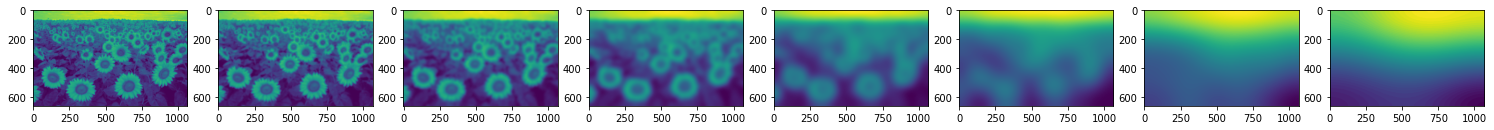

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(26,6))
ax[0].imshow(im_scales[0]), ax[1].imshow(im_scales[1]), ax[2].imshow(im_scales[2]), ax[3].imshow(im_scales[3]), ax[4].imshow(im_scales[4]), ax[5].imshow(im_scales[5]), ax[6].imshow(im_scales[6]), ax[7].imshow(im_scales[7])
fig.show()

#### 8.2 DoG - Difference of gaussians

Now, create the function ```DoG = differenceOfGaussian(im, sigma, n)```, where DoG is the scale \
space DoGs of the original image im. Like the scaleSpaced function, the returned images are all \
the same size as the original.


In [8]:
def differenceOfGaussian(im, sigma, n):
    im_scales = scaleSpaced(im=im, sigma=sigma, n=n)
    DoG = [
        np.int32(im_scales[i + 1]) - np.int32(im_scales[i]) for i in range(n - 1)]
    return DoG

C:\Users\henri\AppData\Local\Temp\ipykernel_8620\3098805373.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


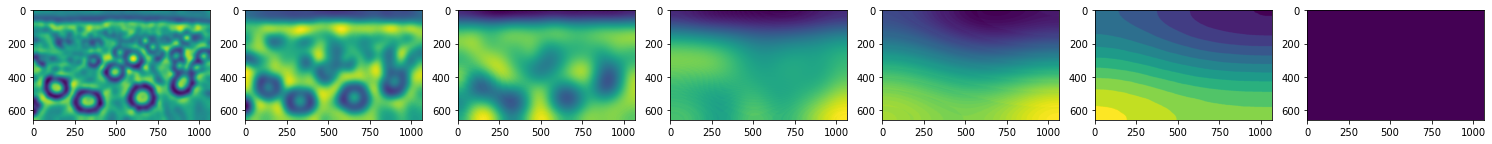

In [9]:
DoG = differenceOfGaussian(im=gray, sigma=15, n=8)
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(26,6))
ax[0].imshow(DoG[0])
ax[1].imshow(DoG[1])
ax[2].imshow(DoG[2])
ax[3].imshow(DoG[3])
ax[4].imshow(DoG[4])
ax[5].imshow(DoG[5])
ax[6].imshow(DoG[6])
fig.show()

#### 8.3 Blob detection

Finally, create the function ```blobs = detectBlobs(im, sigma, n, threshold)```, where blobs are \
the blobs (pixels) of the original image im with a DoG larger than a threshold. You should also \
implement non-maximum suppression to increase the robustness of the detector. \
Try the detector on the image of sunflowers. Visualize your result by drawing a circle for each \
image, with the radius proportional to the scale of the blob. You can use cv2.circle for this.

In [10]:
from scipy import ndimage

In [11]:
def non_maximum_suppression(data, order=1):
    """Detects local maxima in a 3D array

    params:
        : data : 3d ndarray
        : order : int
            How many points on each side to use for the comparison
    return:
        : coords : ndarray
            coordinates of the local maxima
        : values : ndarray
            values of the local maxima
    """
    size = 1 + 2 * order
    footprint = np.ones((size, size, size))
    footprint[order, order, order] = 0

    filtered = ndimage.maximum_filter(data, footprint=footprint)
    mask_local_maxima = data > filtered
    data[~mask_local_maxima] = 0
    
    return data

In [12]:
# TODO: smarter threshold - applied after non-max
def detectBlobs(im, sigma, n, threshold, order=1):
    """
    A simple blob detction algorithm using thresholding and non-max-supression of DoGs
    to detect. It's simple as it does not incorporate rotation assignment or discarding 
    of edge blobs.
        params:
            - im: the grayscaled input image where blobs will be sought.
            - sigma: the variance used in the first layer of DoGs
            - n: The number of gaussians produced. More gaussians are required for scale invariance.
            - threshold: Simple thresholding of DoG to discard non-blob objects.
            - order: size of 3D kernel used for non-max-supression of blobs
        return:
            - A tuple (xs, ys, rs, vals) of pixel coordinates of blobs in original image, and what blurr level
            the point was chosen from, and what values those points held
    """
    # 1 Get all DoGs 
    DoG = differenceOfGaussian(im=im,sigma=sigma, n=n)
    # 2 Stack them all
    stack = np.array([DoG[i] for i in range(len(DoG))])
    # 3 Non max supression in 3D
    stack = non_maximum_suppression(stack, order=order)
    # 5 Get non-zero location
    xs, ys, vals = [], [], []
    rs = np.array([1], dtype=np.uint8)
    for i in range(len(DoG)):
        x, y = np.where(stack[i]>threshold)
        xs += list(x)
        ys += list(y)
        vals += list(stack[i][x, y])
        rs = np.hstack((rs, np.ones(shape=(len(x),), dtype=np.uint8)*(i+1)))
    return (np.array(xs), np.array(ys), rs[1:], np.array(vals))

In [13]:
blobs = detectBlobs(im=gray, sigma=1, n=8, threshold=20, order=2)
print("Amount of blobs:", len(blobs[0]))
print("Mean value of maximas:", np.mean(blobs[3]))

Amount of blobs: 244
Mean value of maximas: 29.204918032786885


**Draw the blobs as cirlces, where radius is bluriness**

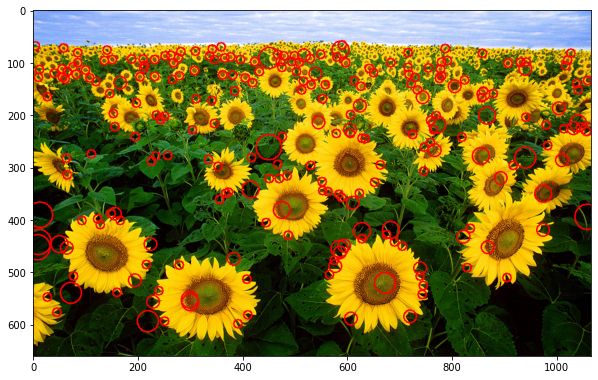

In [14]:
im_copy = img.copy()
b,g,r = cv2.split(im_copy)
im_copy = cv2.merge([r,g,b])

for i in range(len(blobs[0])):
    cv2.circle(img=im_copy, center=(blobs[1][i], blobs[0][i]), radius=blobs[2][i]*4, color=(255, 0, 0), thickness=2)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(im_copy);

# Using SIFT

The SIFT feature detector and matcher are quite difficult to implement, so we will use existing \
implementations. However, first we need a good test case scenario.

#### 8.4 

Create the function ```r_im = transformIm(im, theta, s)```, where r_im is a scaled and rotated \
version of the original image im. In this case, theta is a rotation angle and s is a scale factor. \
Use this function to produce a transformed version of the test image r_im3.

In [15]:
from scipy.spatial.transform import Rotation
import math

In [16]:
def transformIm(im, theta, s):
    # Setup
    w, h = im.shape
    y, x = np.meshgrid(
        np.linspace(0, w, w, dtype=int), np.linspace(0, h, h, dtype=int))
    x=x.flatten() * s
    y=y.flatten() * s
    locs = np.vstack((x, y))

    # Rotate
    theta = theta*np.pi/180
    R = np.array([[np.cos(theta), np.sin(theta)],
                    [-np.sin(theta), np.cos(theta)]])
    # Rotate
    rotated = R@locs
    # Scale
    rotated[0, :] = rotated[0, :] - rotated[0, :].min()
    rotated[1, :] = rotated[1, :] - rotated[1, :].min()

    # Create canvas 
    x_axis = math.ceil(rotated[0, :].max()-rotated[0, :].min())
    y_axis = math.ceil(rotated[1, :].max()-rotated[1, :].min())
    canvas = np.zeros(shape=(y_axis, x_axis))*im.min()
    canvas[::2] = im.max() # To break up the flat surface
    # Draw onto canvas
    for i in range(len(im[0])):
        for j in range(len(im[:, i])):
            iteration = i * len(im[:, i]) + j
            xpos = np.int32(rotated[0, iteration])
            ypos = np.int32(rotated[1, iteration])
            color = im[j, i]
            canvas[ypos, xpos] = color
            
    return np.uint8(canvas)

(136, 136)


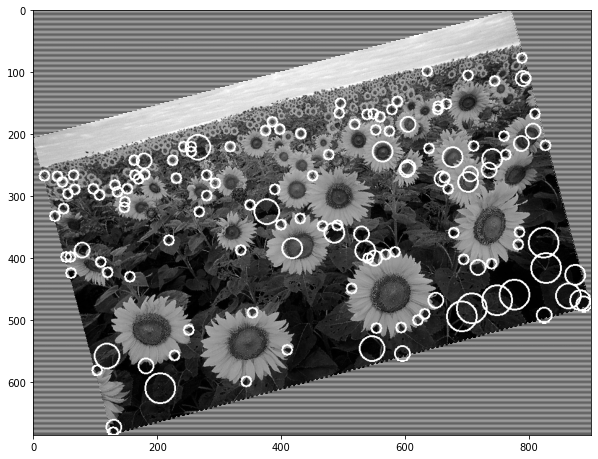

In [17]:
r_im = transformIm(gray, theta=15, s=0.75)
blobs = detectBlobs(im=r_im, sigma=1, n=8, threshold=20, order=2)
print((len(blobs[0]), len(blobs[1])))

for i in range(len(blobs[0])):
    cv2.circle(img=r_im, center=(blobs[1][i], blobs[0][i]), radius=blobs[2][i]*4, color=(255, 0, 0), thickness=2)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(r_im, cmap="gray");

(141, 141)


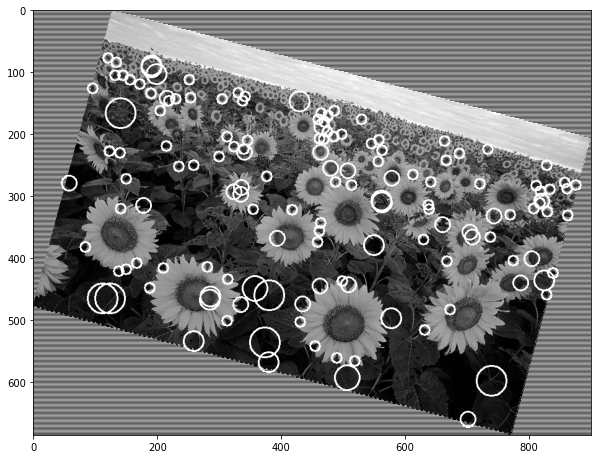

In [18]:
r_im = transformIm(gray, theta=-15, s=0.75)
blobs = detectBlobs(im=r_im, sigma=1, n=8, threshold=20, order=2)
print((len(blobs[0]), len(blobs[1])))
for i in range(len(blobs[0])):
    cv2.circle(img=r_im, center=(blobs[1][i], blobs[0][i]), radius=blobs[2][i]*4, color=(255, 0, 0), thickness=2)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(r_im, cmap="gray");

**Notice**
- Choose to set the canvas to every other value 0, every other value 255 - so that it would not be concidered blobs.

#### 8.5 SIFT detector

Use the SIFT detector to detect features in both the original and the transformed image. Plot the \
features on top of the images. There are quite a few parameters to play with. Try changing them \
and see the results. \
Now match the features to each other. For this you can use cv2.BFMatcher(). \
Plot the matches; do they look qualitatively correct? 

Filter your matches with the ratio test. Does this remove incorrect matches?



In [19]:
t1 = transformIm(gray, theta=-10, s=0.75)
t2 = transformIm(gray, theta=10, s=0.75)

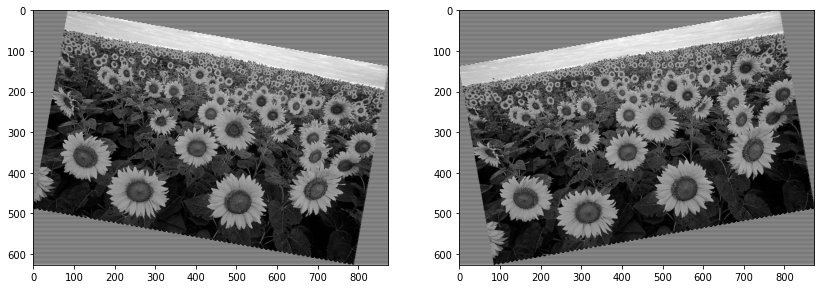

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
axs[0].imshow(t1, cmap="gray")
axs[1].imshow(t2, cmap="gray")

In [21]:
# Use SIFT to getkeypoints and their descriptors
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, # no.best features to retain
                                   nOctaveLayers = 5, # Octave layer in DoG - automatically computed
                                   contrastThreshold = 0.04, #Filter out weak features in semi-uniform regions. The larger the threshold, the less features are produced by the detector.
                                   edgeThreshold = 10000, # Filter out edge-like features. The larger this Threshold, the less features are filtered out. 
                                   sigma = 1.6 ) # Sigma of the gaussian at octave 0
kp1, des1 = sift.detectAndCompute(t1, None) #Keypoints and descriptors
kp2, des2 = sift.detectAndCompute(t2, None) #Keypoints and descriptors

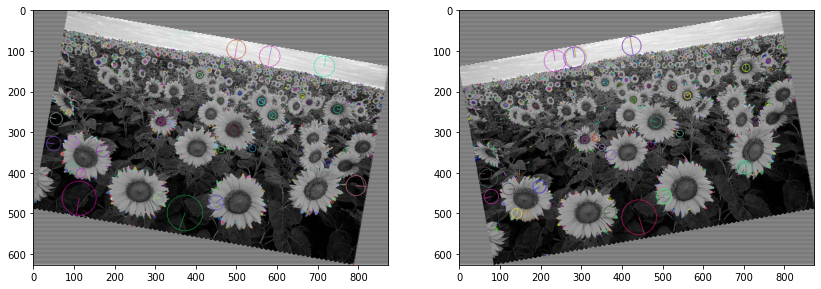

In [22]:
# Draw the keypoints on the images
kp1_img = cv2.drawKeypoints(t1, kp1, t1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_img = cv2.drawKeypoints(t2, kp2, t2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
axs[0].imshow(kp1_img, cmap="gray")
axs[1].imshow(kp2_img, cmap="gray")

In [23]:
# Match using the brute force matcher
bf = cv2.BFMatcher()
matches_1 = bf.match(des1, des2)
matches_2 = bf.knnMatch(des1,des2,k=2)

**Using sorted matches** the bf.match allows you to sort the matches so that only the closest matches are displayed.

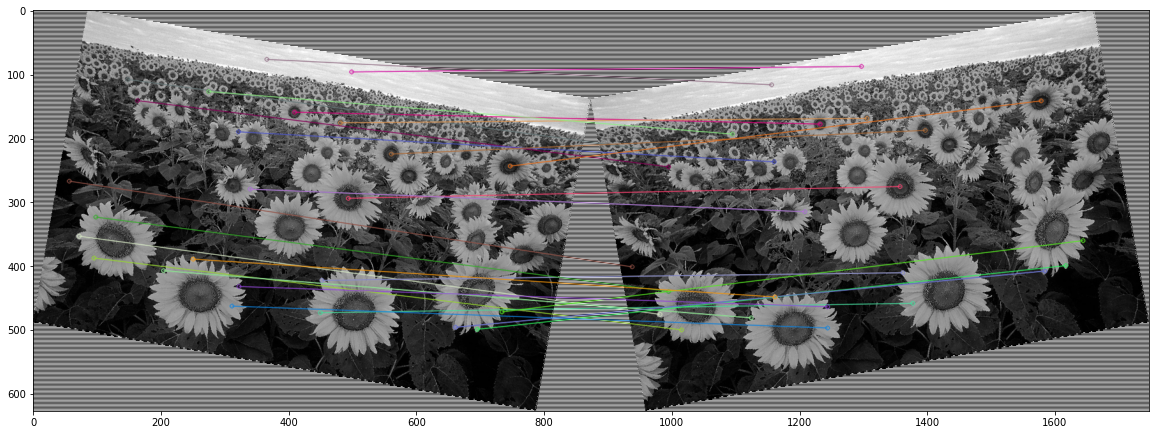

In [24]:
# We can sort the matches, to get the closest matches first
sorted_matches = sorted(matches_1, key = lambda x:x.distance)
# We then draw our matches onto one image
img3 = cv2.drawMatches(t1,kp1,t2,kp2,sorted_matches[:30],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#
plt.figure(figsize = (20,20))
plt.imshow(img3)

**Filter matches** using the ratio test from the lecture, on the KNN matcher
- KNN matcher contains two and two matchees (best and second best)

In [25]:
# only keep matches that are distinctive enough
good = []
for m,n in matches_2:
    if m.distance < 0.75*n.distance:
        good.append([m])
print("Distinctive matches:", len(good))

Distinctive matches: 399


**First before ratio test** 

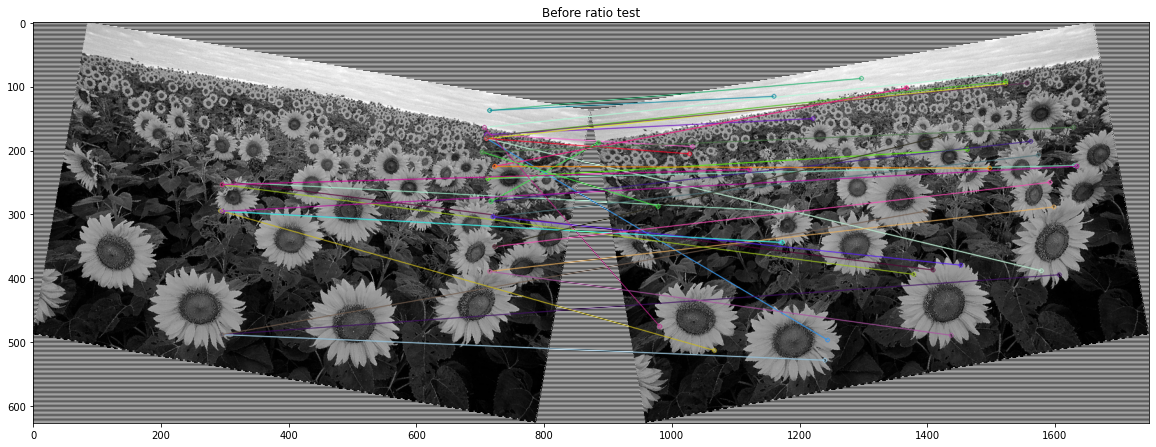

In [26]:
# We then draw our matches onto one image
img4 = cv2.drawMatchesKnn(t1,kp1,t2,kp2,matches_2[:20],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(img4)
plt.title("Before ratio test");

**Then after ratio test**

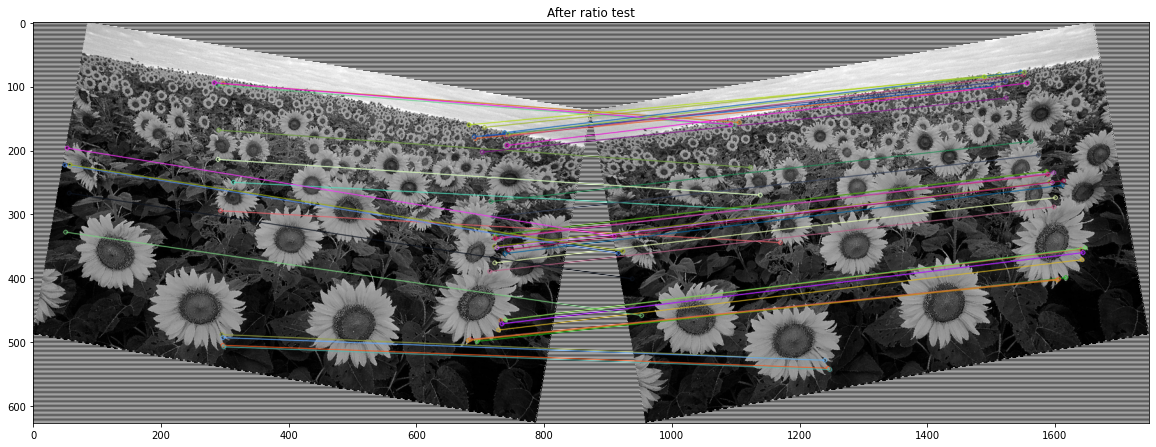

In [27]:
# We then draw our matches onto one image
img5 = cv2.drawMatchesKnn(t1,kp1,t2,kp2,good[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(img5)
plt.title("After ratio test");

**Conclusion**

Both sorting matches by distance and using ratio test worked really well in providing good matches, with only few misses. 

#### 8.6 Home-photography

In [41]:
# Load image
left_color = cv2.imread('week08_data/image_from_left.jpg')
left = cv2.cvtColor(left_color, cv2.COLOR_RGB2GRAY)
right_color = cv2.imread('week08_data/image_from_right.jpg')
right = cv2.cvtColor(right_color, cv2.COLOR_RGB2GRAY)

# Need to scale down images for better visualization
scale_percent = 20 # percent of original size
width = int(right.shape[1] * scale_percent / 100)
height = int(right.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
right = cv2.resize(right, dim, interpolation = cv2.INTER_AREA)
left = cv2.resize(left, dim, interpolation = cv2.INTER_AREA)

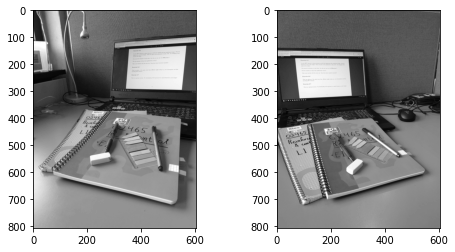

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(right, cmap="gray")
ax[1].imshow(left, cmap="gray")

In [43]:
# Use SIFT to getkeypoints and their descriptors
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(right, None)
kp2, des2 = sift.detectAndCompute(left, None)

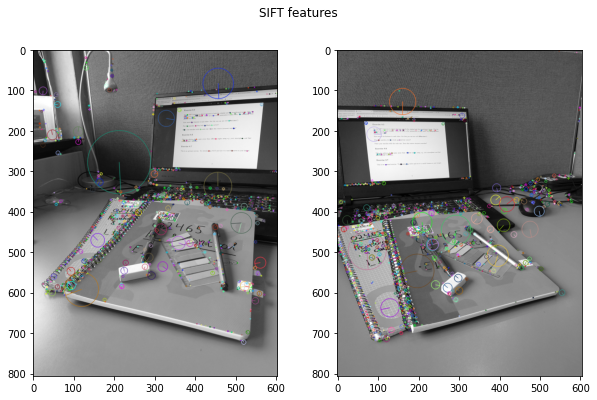

In [44]:
# Draw the keypoints on the images
kp1_img = cv2.drawKeypoints(right, kp1, right, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_img = cv2.drawKeypoints(left, kp2, left, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
axs[0].imshow(kp1_img, cmap="gray")
axs[1].imshow(kp2_img, cmap="gray")
fig.suptitle("SIFT features");

In [32]:
# Match using the brute force matcher or KNN matcher
bf = cv2.BFMatcher()
matches_1 = bf.match(des1, des2)
matches_2 = bf.knnMatch(des1, des2, k=2)

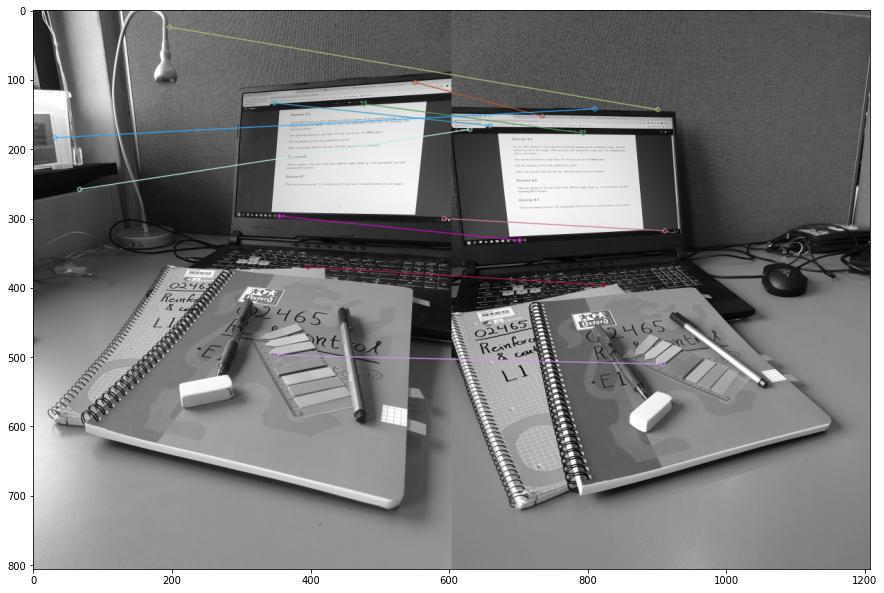

In [33]:
# We can sort the matches, to get the closest matches first
sorted_matches = sorted(matches_1, key = lambda x:x.distance)
# We then draw our matches onto one image
img6 = cv2.drawMatches(right,kp1,left,kp2,sorted_matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15))
plt.imshow(img6)

**Now we can see the method struggeling a bit more**
- About 20% of matches seem to be off
- It seems to struggle with objects "leaving the frame": too big angle between each image

**Lets try the KNN matches with ratio test**

In [34]:
# only keep matches that are distinctive enough
good = []
for m,n in matches_2:
    if m.distance < 0.75*n.distance:
        good.append([m])
print("Distinctive matches:", len(good))

Distinctive matches: 47


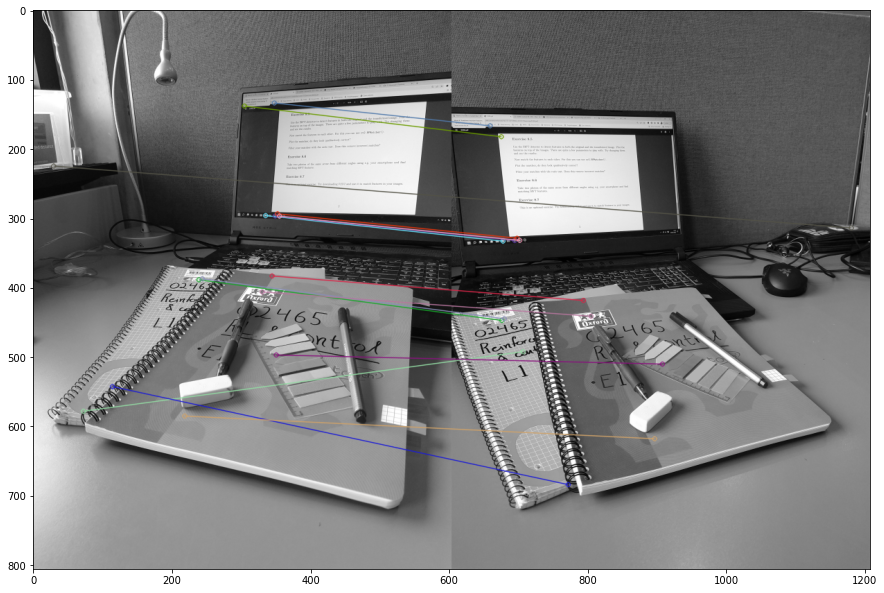

In [35]:
## We then draw our matches onto one image
img7 = cv2.drawMatchesKnn(right, kp1, left, kp2, good[:15],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15))
plt.imshow(img7)

**The KNN matcher with ratio test**:
- Seems to do a bit better! The struggle still seems to be when objects leave the frame.

#### 8.5
The R2D2 is a "repeatable and reliable detector and descriptor", presented in 2019. 

```Abstract```\
"Interest point detection and local feature description are fundamental steps in many computer vision applications. Classical approaches are based on a detect-then-describe paradigm where separate handcrafted methods are used to first identify repeatable keypoints and then represent them with a local descriptor. 

Neural networks trained with metric learning losses have recently caught up with these techniques, focusing on learning repeatable saliency maps for keypoint detection or learning descriptors at the detected keypoint locations. 

In this work, we argue that repeatable regions are not necessarily discriminative and can therefore lead to select suboptimal keypoints. Furthermore, we claim that descriptors should be learned only in regions for which matching can be performed with high confidence. We thus propose to jointly learn keypoint detection and description together with a predictor of the local descriptor discriminativeness. This allows to avoid ambiguous areas, thus leading to reliable keypoint detection and description. Our detection-and-description approach simultaneously outputs sparse, repeatable and reliable keypoints that outperforms state-of-the-art detectors and descriptors on the HPatches dataset and on the recent Aachen Day-Night localization benchmark."


https://www.youtube.com/watch?v=ywypX9TWAsE&ab_channel=AIP-State-of-the-ArtAIResearch


In [36]:
#%run r2d2-master/extract.py --model models/r2d2_WASF_N16.pt --images week08_data/image_from_right.jpg --top-k 5000

**Oh no...** The GPU is odler than the CUDA software. Could try to install an older version of CUDA.

#### Extra testing for fun

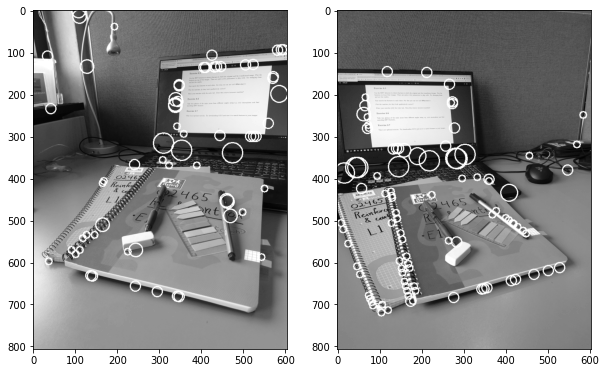

In [37]:
# Left
blobs = detectBlobs(im=left, sigma=1, n=8, threshold=20, order=2)

for i in range(len(blobs[0])):
    cv2.circle(img=left, center=(blobs[1][i], blobs[0][i]), radius=blobs[2][i]*4, color=(255, 0, 0), thickness=2)

# right
blobs = detectBlobs(im=right, sigma=1, n=8, threshold=20, order=2)
for i in range(len(blobs[0])):
    cv2.circle(img=right, center=(blobs[1][i], blobs[0][i]), radius=blobs[2][i]*4, color=(255, 0, 0), thickness=2)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(right, cmap="gray")
ax[1].imshow(left, cmap="gray");

**TODO** USE homemade keypoints with SIFT descriptors to match images!